# [DLthon] 오늘의 계획
- 모델 최적화 (W&B 활용)
- Data별 결과 분석
- 발표 내용 구성

# 선정 모델: EfficientNetB0

In [1]:
!pip install wandb==0.16.0

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import os

# W&B 설정
import wandb
from wandb.keras import WandbMetricsLogger
from wandb.integration.keras import WandbCallback

In [3]:
# 키 파일 경로
key_file_path = "./wandb/wandb_key.txt"

# 파일에서 W&B 키 불러오기
with open(key_file_path, "r") as f:
    YOUR_WANDB_KEY = f.read().strip()  # 공백 제거

# W&B 로그인
wandb.login(key=YOUR_WANDB_KEY)

wandb: Currently logged in as: aiffel-es (aiffel-es-none). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /aiffel/.netrc


True

# 최적의 하이퍼파라미터 찾기

### test 1

In [4]:
# 데이터 경로 설정
base_dir = "./Train_Test_Valid_preprocessed"
train_dir = os.path.join(base_dir, "Train_Cleaned")
valid_dir = os.path.join(base_dir, "valid")
test_dir = os.path.join(base_dir, "test")

In [5]:
# W&B Sweep 설정 (하이퍼파라미터 검색)
sweep_config = {
    "method": "grid",  # 모든 조합을 시도하려면 "grid", 무작위 탐색은 "random"
    "metric": {"name": "val_accuracy", "goal": "maximize"},
    "parameters": {
        "learning_rate": {"values": [0.0001]},
        "batch_size": {"values": [16]}, 
        "dropout_rate": {"values": [0.2]}, 
        "epochs": {"values": [10]} 
    },
}

In [6]:
# Sweep 생성
sweep_id = wandb.sweep(sweep_config, project="jellyfish_classification")

Create sweep with ID: qa1sgyow
Sweep URL: https://wandb.ai/aiffel-es-none/jellyfish_classification/sweeps/qa1sgyow


wandb: Agent Starting Run: a6vh5q9n with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001


Found 846 images belonging to 6 classes.
Found 99 images belonging to 6 classes.
Epoch 1/10
53/53 [==============================] - 25s 252ms/step - loss: 1.3750 - accuracy: 0.5343 - val_loss: 1.0547 - val_accuracy: 0.6566
Epoch 2/10
53/53 [==============================] - 11s 196ms/step - loss: 0.6369 - accuracy: 0.8251 - val_loss: 0.6999 - val_accuracy: 0.7475
Epoch 3/10
53/53 [==============================] - 10s 196ms/step - loss: 0.3136 - accuracy: 0.9184 - val_loss: 0.6573 - val_accuracy: 0.7778
Epoch 4/10
53/53 [==============================] - 11s 198ms/step - loss: 0.1889 - accuracy: 0.9456 - val_loss: 0.6711 - val_accuracy: 0.7677
Epoch 5/10
53/53 [==============================] - 11s 196ms/step - loss: 0.1176 - accuracy: 0.9657 - val_loss: 0.6045 - val_accuracy: 0.7879
Epoch 6/10
53/53 [==============================] - 10s 192ms/step - loss: 0.0960 - accuracy: 0.9799 - val_loss: 0.6084 - val_accuracy: 0.7980
Epoch 7/10
53/53 [==============================] - 10s 195ms

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


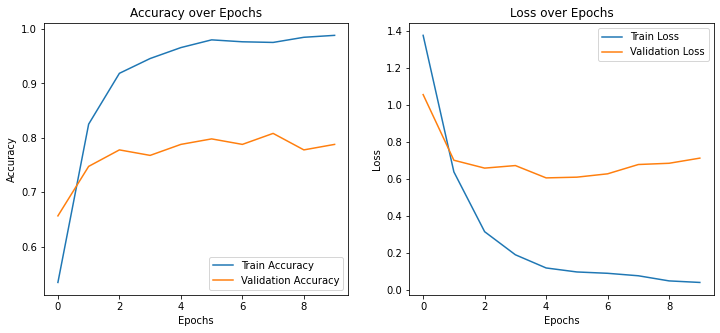

accuracy,▁
epoch/accuracy,▁▅▇▇██████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,███████▁▁▁
epoch/loss,█▄▂▂▁▁▁▁▁▁
epoch/lr,████████▁▁
epoch/val_accuracy,▁▅▇▆▇█▇█▇▇
epoch/val_loss,█▂▂▂▁▁▁▂▂▃
loss,▁
test_accuracy,▁
test_loss,▁


In [7]:
# Sweep을 위한 학습 함수
def train_sweep():
    with wandb.init():
        config = wandb.config  # Sweep 하이퍼파라미터 가져오기
        
        # EfficientNetB0 모델 불러오기
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

        # 새 Fully Connected Layer 추가
        x = GlobalAveragePooling2D()(base_model.output)
        x = Dense(512, activation='relu')(x)
        x = Dropout(config.dropout_rate)(x)  # Sweep에서 dropout 값을 자동으로 변경
        x = Dense(6, activation='softmax')(x)

        # 새로운 모델 생성
        model = Model(inputs=base_model.input, outputs=x)

        # EfficientNetB0 일부 레이어만 학습 가능하도록 설정
        for layer in base_model.layers[:-50]:  # 마지막 50개 레이어만 학습
            layer.trainable = True

        # 모델 컴파일
        model.compile(optimizer=Adam(learning_rate=config.learning_rate),
                      loss='categorical_crossentropy', metrics=['accuracy'])

        # 데이터 증강 및 전처리
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True
        )
        valid_test_datagen = ImageDataGenerator(rescale=1./255)

        train_generator = train_datagen.flow_from_directory(
            train_dir, target_size=(224, 224), batch_size=config.batch_size, class_mode='categorical')
        val_generator = valid_test_datagen.flow_from_directory(
            valid_dir, target_size=(224, 224), batch_size=config.batch_size, class_mode='categorical')

        # 콜백 함수 설정
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

        # 모델 학습
        history = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=config.epochs,
            callbacks=[early_stopping, reduce_lr, WandbMetricsLogger()]
        )
        
        # 🔹 W&B에 loss, accuracy 기록
        wandb.log({
            "loss": history.history["loss"][-1],
            "val_loss": history.history["val_loss"][-1],
            "accuracy": history.history["accuracy"][-1],
            "val_accuracy": history.history["val_accuracy"][-1]
        })

        # 테스트 데이터 불러오기
        test_generator = valid_test_datagen.flow_from_directory(
            test_dir, target_size=(224, 224), batch_size=config.batch_size, class_mode='categorical')

        # 모델 평가
        loss, acc = model.evaluate(test_generator)

        # 🔹 W&B에 테스트 결과 저장
        wandb.log({
            "test_loss": loss,
            "test_accuracy": acc
        })

        print(f"Test Loss: {loss:.4f}")
        print(f"Test Accuracy: {acc:.4f}")

        # 모델 저장
        model.save(f"efficientnetb0_jellyfish_{wandb.run.name}.h5")

        # 학습 결과 시각화
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Accuracy over Epochs')

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Loss over Epochs')

        plt.show()

        wandb.finish()  # ✅ train_sweep() 내부에서 W&B 종료

# Sweep 실행
wandb.agent(sweep_id, train_sweep, count=1)

### test 2

In [12]:
# 데이터 경로 설정
base_dir = "./Train_Test_Valid_preprocessed"
train_dir = os.path.join(base_dir, "Train_Cleaned")
valid_dir = os.path.join(base_dir, "valid")
test_dir = os.path.join(base_dir, "test")

In [13]:
# W&B Sweep 설정 (하이퍼파라미터 검색)
sweep_config = {
    "method": "grid",  # 모든 조합을 시도하려면 "grid", 무작위 탐색은 "random"
    "metric": {"name": "val_accuracy", "goal": "maximize"},
    "parameters": {
        "learning_rate": {"values": [0.0001]},
        "batch_size": {"values": [16]}, 
        "dropout_rate": {"values": [0.3]}, 
        "epochs": {"values": [20]} 
    },
}

In [14]:
# Sweep 생성
sweep_id = wandb.sweep(sweep_config, project="jellyfish_classification")

Create sweep with ID: 04vad2jn
Sweep URL: https://wandb.ai/aiffel-es-none/jellyfish_classification/sweeps/04vad2jn


wandb: Agent Starting Run: ur85cop7 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001


Found 846 images belonging to 6 classes.
Found 99 images belonging to 6 classes.
Epoch 1/20
53/53 [==============================] - 19s 215ms/step - loss: 1.3942 - accuracy: 0.5035 - val_loss: 1.1718 - val_accuracy: 0.6465
Epoch 2/20
53/53 [==============================] - 10s 194ms/step - loss: 0.6367 - accuracy: 0.8203 - val_loss: 0.7840 - val_accuracy: 0.6768
Epoch 3/20
53/53 [==============================] - 10s 193ms/step - loss: 0.3466 - accuracy: 0.9007 - val_loss: 0.7342 - val_accuracy: 0.6869
Epoch 4/20
53/53 [==============================] - 10s 195ms/step - loss: 0.2440 - accuracy: 0.9243 - val_loss: 0.6620 - val_accuracy: 0.7576
Epoch 5/20
53/53 [==============================] - 10s 192ms/step - loss: 0.1594 - accuracy: 0.9539 - val_loss: 0.6571 - val_accuracy: 0.7778
Epoch 6/20
53/53 [==============================] - 10s 194ms/step - loss: 0.1028 - accuracy: 0.9704 - val_loss: 0.6512 - val_accuracy: 0.7980
Epoch 7/20
53/53 [==============================] - 11s 198ms

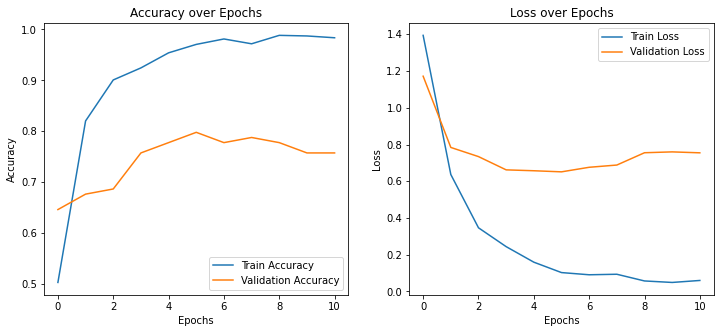

accuracy,▁
epoch/accuracy,▁▆▇▇███████
epoch/epoch,▁▂▂▃▄▅▅▆▇▇█
epoch/learning_rate,████████▁▁▁
epoch/loss,█▄▃▂▂▁▁▁▁▁▁
epoch/lr,█████████▁▁
epoch/val_accuracy,▁▂▃▆▇█▇█▇▆▆
epoch/val_loss,█▃▂▁▁▁▁▁▂▂▂
loss,▁
test_accuracy,▁
test_loss,▁


In [15]:
# Sweep을 위한 학습 함수
def train_sweep():
    with wandb.init():
        config = wandb.config  # Sweep 하이퍼파라미터 가져오기
        
        # EfficientNetB0 모델 불러오기
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

        # 새 Fully Connected Layer 추가
        x = GlobalAveragePooling2D()(base_model.output)
        x = Dense(512, activation='relu')(x)
        x = Dropout(config.dropout_rate)(x)  # Sweep에서 dropout 값을 자동으로 변경
        x = Dense(6, activation='softmax')(x)

        # 새로운 모델 생성
        model = Model(inputs=base_model.input, outputs=x)

        # EfficientNetB0 일부 레이어만 학습 가능하도록 설정
        for layer in base_model.layers[:-50]:  # 마지막 50개 레이어만 학습
            layer.trainable = True

        # 모델 컴파일
        model.compile(optimizer=Adam(learning_rate=config.learning_rate),
                      loss='categorical_crossentropy', metrics=['accuracy'])

        # 데이터 증강 및 전처리
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True
        )
        valid_test_datagen = ImageDataGenerator(rescale=1./255)

        train_generator = train_datagen.flow_from_directory(
            train_dir, target_size=(224, 224), batch_size=config.batch_size, class_mode='categorical')
        val_generator = valid_test_datagen.flow_from_directory(
            valid_dir, target_size=(224, 224), batch_size=config.batch_size, class_mode='categorical')

        # 콜백 함수 설정
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

        # 모델 학습
        history = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=config.epochs,
            callbacks=[early_stopping, reduce_lr, WandbMetricsLogger()]
        )
        
        # 🔹 W&B에 loss, accuracy 기록
        wandb.log({
            "loss": history.history["loss"][-1],
            "val_loss": history.history["val_loss"][-1],
            "accuracy": history.history["accuracy"][-1],
            "val_accuracy": history.history["val_accuracy"][-1]
        })

        # 테스트 데이터 불러오기
        test_generator = valid_test_datagen.flow_from_directory(
            test_dir, target_size=(224, 224), batch_size=config.batch_size, class_mode='categorical')

        # 모델 평가
        loss, acc = model.evaluate(test_generator)

        # 🔹 W&B에 테스트 결과 저장
        wandb.log({
            "test_loss": loss,
            "test_accuracy": acc
        })

        print(f"Test Loss: {loss:.4f}")
        print(f"Test Accuracy: {acc:.4f}")

        # 모델 저장
        model.save(f"efficientnetb0_jellyfish_{wandb.run.name}.h5")

        # 학습 결과 시각화
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Accuracy over Epochs')

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Loss over Epochs')

        plt.show()

        wandb.finish()  # ✅ train_sweep() 내부에서 W&B 종료

# Sweep 실행
wandb.agent(sweep_id, train_sweep, count=1)

### test 3

In [16]:
# 데이터 경로 설정
base_dir = "./Train_Test_Valid_preprocessed"
train_dir = os.path.join(base_dir, "Train_Cleaned")
valid_dir = os.path.join(base_dir, "valid")
test_dir = os.path.join(base_dir, "test")

In [17]:
# W&B Sweep 설정 (하이퍼파라미터 검색)
sweep_config = {
    "method": "grid",  # 모든 조합을 시도하려면 "grid", 무작위 탐색은 "random"
    "metric": {"name": "val_accuracy", "goal": "maximize"},
    "parameters": {
        "learning_rate": {"values": [0.0001]},
        "batch_size": {"values": [16]}, 
        "dropout_rate": {"values": [0.25]}, 
        "epochs": {"values": [20]} 
    },
}

In [18]:
# Sweep 생성
sweep_id = wandb.sweep(sweep_config, project="jellyfish_classification")

Create sweep with ID: 85u25ca0
Sweep URL: https://wandb.ai/aiffel-es-none/jellyfish_classification/sweeps/85u25ca0


wandb: Agent Starting Run: n7geg9z9 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.25
wandb: 	epochs: 20
wandb: 	learning_rate: 0.0001


Found 846 images belonging to 6 classes.
Found 99 images belonging to 6 classes.
Epoch 1/20
53/53 [==============================] - 19s 220ms/step - loss: 1.3912 - accuracy: 0.5414 - val_loss: 1.1181 - val_accuracy: 0.6364
Epoch 2/20
53/53 [==============================] - 10s 193ms/step - loss: 0.6496 - accuracy: 0.8251 - val_loss: 0.7372 - val_accuracy: 0.7374
Epoch 3/20
53/53 [==============================] - 10s 195ms/step - loss: 0.3443 - accuracy: 0.9054 - val_loss: 0.6234 - val_accuracy: 0.7879
Epoch 4/20
53/53 [==============================] - 11s 198ms/step - loss: 0.2141 - accuracy: 0.9338 - val_loss: 0.6544 - val_accuracy: 0.7879
Epoch 5/20
53/53 [==============================] - 11s 196ms/step - loss: 0.1953 - accuracy: 0.9444 - val_loss: 0.6036 - val_accuracy: 0.7980
Epoch 6/20
53/53 [==============================] - 10s 195ms/step - loss: 0.1316 - accuracy: 0.9586 - val_loss: 0.6262 - val_accuracy: 0.7778
Epoch 7/20
53/53 [==============================] - 10s 196ms

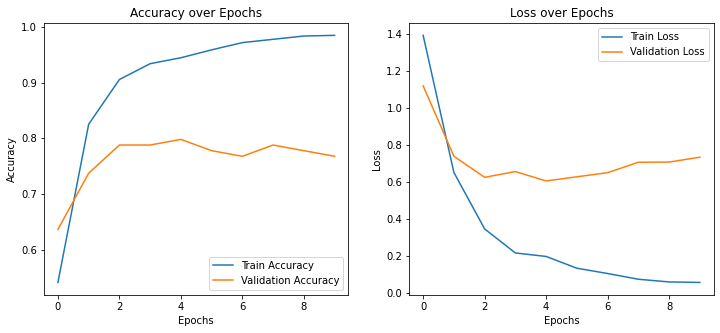

accuracy,▁
epoch/accuracy,▁▅▇▇▇█████
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,███████▁▁▁
epoch/loss,█▄▃▂▂▁▁▁▁▁
epoch/lr,████████▁▁
epoch/val_accuracy,▁▅███▇▇█▇▇
epoch/val_loss,█▃▁▂▁▁▂▂▂▃
loss,▁
test_accuracy,▁
test_loss,▁


In [19]:
# Sweep을 위한 학습 함수
def train_sweep():
    with wandb.init():
        config = wandb.config  # Sweep 하이퍼파라미터 가져오기
        
        # EfficientNetB0 모델 불러오기
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

        # 새 Fully Connected Layer 추가
        x = GlobalAveragePooling2D()(base_model.output)
        x = Dense(512, activation='relu')(x)
        x = Dropout(config.dropout_rate)(x)  # Sweep에서 dropout 값을 자동으로 변경
        x = Dense(6, activation='softmax')(x)

        # 새로운 모델 생성
        model = Model(inputs=base_model.input, outputs=x)

        # EfficientNetB0 일부 레이어만 학습 가능하도록 설정
        for layer in base_model.layers[:-50]:  # 마지막 50개 레이어만 학습
            layer.trainable = True

        # 모델 컴파일
        model.compile(optimizer=Adam(learning_rate=config.learning_rate),
                      loss='categorical_crossentropy', metrics=['accuracy'])

        # 데이터 증강 및 전처리
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True
        )
        valid_test_datagen = ImageDataGenerator(rescale=1./255)

        train_generator = train_datagen.flow_from_directory(
            train_dir, target_size=(224, 224), batch_size=config.batch_size, class_mode='categorical')
        val_generator = valid_test_datagen.flow_from_directory(
            valid_dir, target_size=(224, 224), batch_size=config.batch_size, class_mode='categorical')

        # 콜백 함수 설정
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

        # 모델 학습
        history = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=config.epochs,
            callbacks=[early_stopping, reduce_lr, WandbMetricsLogger()]
        )
        
        # 🔹 W&B에 loss, accuracy 기록
        wandb.log({
            "loss": history.history["loss"][-1],
            "val_loss": history.history["val_loss"][-1],
            "accuracy": history.history["accuracy"][-1],
            "val_accuracy": history.history["val_accuracy"][-1]
        })

        # 테스트 데이터 불러오기
        test_generator = valid_test_datagen.flow_from_directory(
            test_dir, target_size=(224, 224), batch_size=config.batch_size, class_mode='categorical')

        # 모델 평가
        loss, acc = model.evaluate(test_generator)

        # 🔹 W&B에 테스트 결과 저장
        wandb.log({
            "test_loss": loss,
            "test_accuracy": acc
        })

        print(f"Test Loss: {loss:.4f}")
        print(f"Test Accuracy: {acc:.4f}")

        # 모델 저장
        model.save(f"efficientnetb0_jellyfish_{wandb.run.name}.h5")

        # 학습 결과 시각화
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Accuracy over Epochs')

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Loss over Epochs')

        plt.show()

        wandb.finish()  # ✅ train_sweep() 내부에서 W&B 종료

# Sweep 실행
wandb.agent(sweep_id, train_sweep, count=1)

## test 4 → 최적의 하이퍼파라미터 확정

In [22]:
# 데이터 경로 설정
base_dir = "./Train_Test_Valid_preprocessed"
train_dir = os.path.join(base_dir, "Train_Cleaned")
valid_dir = os.path.join(base_dir, "valid")
test_dir = os.path.join(base_dir, "test")

In [23]:
# W&B Sweep 설정 (하이퍼파라미터 검색)
sweep_config = {
    "method": "grid",  # 모든 조합을 시도하려면 "grid", 무작위 탐색은 "random"
    "metric": {"name": "val_accuracy", "goal": "maximize"},
    "parameters": {
        "learning_rate": {"values": [0.0001]},
        "batch_size": {"values": [16]}, 
        "dropout_rate": {"values": [0.5]}, 
        "epochs": {"values": [30]} 
    },
}

In [24]:
# Sweep 생성
sweep_id = wandb.sweep(sweep_config, project="jellyfish_classification")

Create sweep with ID: p02izc30
Sweep URL: https://wandb.ai/aiffel-es-none/jellyfish_classification/sweeps/p02izc30


wandb: Agent Starting Run: zcxmpjn5 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001


Found 846 images belonging to 6 classes.
Found 99 images belonging to 6 classes.
Epoch 1/30
53/53 [==============================] - 20s 231ms/step - loss: 1.5068 - accuracy: 0.4314 - val_loss: 1.2408 - val_accuracy: 0.5657
Epoch 2/30
53/53 [==============================] - 10s 195ms/step - loss: 0.7936 - accuracy: 0.7908 - val_loss: 0.8535 - val_accuracy: 0.6768
Epoch 3/30
53/53 [==============================] - 11s 197ms/step - loss: 0.4817 - accuracy: 0.8404 - val_loss: 0.7326 - val_accuracy: 0.7475
Epoch 4/30
53/53 [==============================] - 10s 195ms/step - loss: 0.3313 - accuracy: 0.8913 - val_loss: 0.6612 - val_accuracy: 0.7879
Epoch 5/30
53/53 [==============================] - 10s 194ms/step - loss: 0.2200 - accuracy: 0.9279 - val_loss: 0.6464 - val_accuracy: 0.7778
Epoch 6/30
53/53 [==============================] - 10s 194ms/step - loss: 0.1538 - accuracy: 0.9527 - val_loss: 0.6556 - val_accuracy: 0.7879
Epoch 7/30
53/53 [==============================] - 10s 193ms

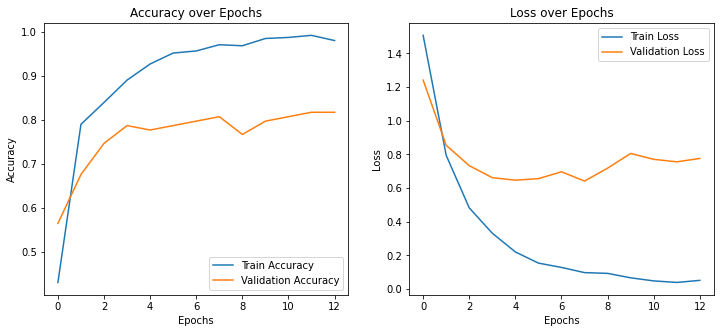

accuracy,▁
epoch/accuracy,▁▅▆▇▇▇███████
epoch/epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
epoch/learning_rate,██████████▁▁▁
epoch/loss,█▅▃▂▂▂▁▁▁▁▁▁▁
epoch/lr,███████████▁▁
epoch/val_accuracy,▁▄▆▇▇▇▇█▇▇███
epoch/val_loss,█▃▂▁▁▁▂▁▂▃▃▂▃
loss,▁
test_accuracy,▁
test_loss,▁


In [25]:
# Sweep을 위한 학습 함수
def train_sweep():
    with wandb.init():
        config = wandb.config  # Sweep 하이퍼파라미터 가져오기
        
        # EfficientNetB0 모델 불러오기
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

        # 새 Fully Connected Layer 추가
        x = GlobalAveragePooling2D()(base_model.output)
        x = Dense(512, activation='relu')(x)
        x = Dropout(config.dropout_rate)(x)  # Sweep에서 dropout 값을 자동으로 변경
        x = Dense(6, activation='softmax')(x)

        # 새로운 모델 생성
        model = Model(inputs=base_model.input, outputs=x)

        # EfficientNetB0 일부 레이어만 학습 가능하도록 설정
        for layer in base_model.layers[:-50]:  # 마지막 50개 레이어만 학습
            layer.trainable = True

        # 모델 컴파일
        model.compile(optimizer=Adam(learning_rate=config.learning_rate),
                      loss='categorical_crossentropy', metrics=['accuracy'])

        # 데이터 증강 및 전처리
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True
        )
        valid_test_datagen = ImageDataGenerator(rescale=1./255)

        train_generator = train_datagen.flow_from_directory(
            train_dir, target_size=(224, 224), batch_size=config.batch_size, class_mode='categorical')
        val_generator = valid_test_datagen.flow_from_directory(
            valid_dir, target_size=(224, 224), batch_size=config.batch_size, class_mode='categorical')

        # 콜백 함수 설정
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True,verbose=1)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6,verbose=1)

        # 모델 학습
        history = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=config.epochs,
            callbacks=[early_stopping, reduce_lr, WandbMetricsLogger()]
        )
        
        # 🔹 W&B에 loss, accuracy 기록
        wandb.log({
            "loss": history.history["loss"][-1],
            "val_loss": history.history["val_loss"][-1],
            "accuracy": history.history["accuracy"][-1],
            "val_accuracy": history.history["val_accuracy"][-1]
        })

        # 테스트 데이터 불러오기
        test_generator = valid_test_datagen.flow_from_directory(
            test_dir, target_size=(224, 224), batch_size=config.batch_size, class_mode='categorical')

        # 모델 평가
        loss, acc = model.evaluate(test_generator)

        # 🔹 W&B에 테스트 결과 저장
        wandb.log({
            "test_loss": loss,
            "test_accuracy": acc
        })

        print(f"Test Loss: {loss:.4f}")
        print(f"Test Accuracy: {acc:.4f}")

        # 모델 저장
        model.save(f"efficientnetb0_jellyfish_{wandb.run.name}.h5")

        # 학습 결과 시각화
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Accuracy over Epochs')

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Loss over Epochs')

        plt.show()

        wandb.finish()  # ✅ train_sweep() 내부에서 W&B 종료

# Sweep 실행
wandb.agent(sweep_id, train_sweep, count=1)